# Pruning Strategies for Accelerated KNN Search

This document outlines a triangle-inequality-based pruning approach for accelerating K-Nearest Neighbor (KNN) queries. It complements existing algorithms like VA+-File and HNSW by eliminating candidates **without directly computing distances**, based on **precomputed inter-vector distances** and geometric reasoning.

---

## 🎯 Goal

To speed up KNN search by **pruning the candidate set** during query time. The approach uses:
- Precomputed distances between vectors
- Triangle inequality
- KNN ball geometry  
to eliminate vectors that cannot possibly be among the $k$-nearest neighbors of the query.

---

## 🧠 Core Ideas

1. **Track the KNN Ball of the Query**  
   - Maintain the distance $R$ to the current $k$-th nearest neighbor of query $q$.  
   - All valid neighbors must lie within a ball of radius $R$ centered at $q$.

2. **Use Triangle Inequality for Pruning**  
   - As you compute distances $\|q - v\|$, eliminate other vectors $x$ without computing $\|q - x\|$ directly.

3. **Store Only Useful Distances**  
   - Avoid storing all $n^2$ distances. Instead, keep only:
     - $m$ closest vectors (for "too far" tests)
     - $m$ farthest vectors (for "too close" tests)

---

## 🔒 Pruning Rules

### Rule 1: Local Ball Exclusion

If $\|q - v\| > R$, then:

> Eliminate all vectors $x$ such that:  
> $$
\|x - v\| < \|q - v\| - R
$$

These points are **too close to $v$** to be inside $q$’s KNN ball.

---

### Rule 2: Global Ball Exclusion

If $\|q - v\| > R$, then:

> Eliminate all vectors $x$ such that:  
> $$
\|x - v\| > \|q - v\| + R
$$

These points are **too far from both $q$ and $v$** to be relevant.

---

## 💾 Efficient Distance Storage

Full pairwise distance matrices require $\mathcal{O}(n^2)$ space — infeasible at large scale. Instead:

- Store only the **top‑$m$ closest** and **top‑$m$ farthest** distances per vector
- Total storage becomes $\mathcal{O}(nm)$, e.g., 800MB for $n = 10^6$, $m = 100$
- These are sufficient for most pruning conditions

---

## 🧭 Guided Neighborhood Traversal (HNSW-Inspired)

In the enhanced version of Ball Prune, we replace random candidate selection with **neighborhood-guided traversal**, inspired by HNSW:

- Begin from a **random starting point**
- Maintain a **frontier queue** of promising candidates, seeded by exploring **precomputed nearest neighbors**
- If a candidate improves the KNN heap, we enqueue its neighbors for exploration
- This guided traversal accelerates convergence to good KNNs, shrinking the pruning radius $R$ earlier

> 🧠 **Intuition**:  
> If a point is close to the query, then its nearest neighbors are likely good candidates too.

This approach quickly homes in on relevant regions of the dataset, leading to **fewer distance computations and earlier pruning**.

---

## 🔗 Integration with Existing Algorithms

This pruning strategy is compatible with:

- **VA+-File**: Apply pruning between phase 1 (approximate filtering) and phase 2 (exact distance checks)
- **HNSW / DiskANN**: Use pruning during traversal to avoid visiting neighbors unnecessarily
- **Brute-force search**: Skip computing many distances even after reading a block into RAM

---

## ⚡ Benefits

| Feature                  | Advantage |
|--------------------------|-----------|
| 🚫 Fewer distance computations | Especially helpful for costly metrics (e.g., Mahalanobis) |
| 💽 Reduced I/O                | Avoid unnecessary disk reads |
| 📦 Lower memory usage        | Sparse distance storage scales |
| 🔄 Plug-and-play             | Works with any KNN method |
| 🎯 Geometrically precise     | Real geometry-based filtering, not heuristics |


In [26]:
import numpy as np
from typing import List, Tuple
import bisect
import heapq

def euclidean_distance(a: np.ndarray, b: np.ndarray) -> float:
    return np.linalg.norm(a - b)

def ball_prune_knn(
    query: np.ndarray,
    dataset: np.ndarray,
    k: int,
    max_dists: dict,
    min_dists: dict
) -> List[Tuple[int, float]]:
    """
    Perform approximate KNN search using the Ball Prune strategy with Euclidean distances.

    Args:
        query: np.ndarray, shape (d,)
        dataset: np.ndarray, shape (n, d)
        k: int, number of neighbors to find
        max_dists: dict of i -> list of (j, dist) sorted ascending
        min_dists: dict of i -> list of (j, dist) sorted ascending

    Returns:
        List of (index, distance) of the k nearest neighbors to query
    """
    n = dataset.shape[0]
    candidate_indices = set(range(n))
    heap = []  # Min-heap of (−dist, idx)

    prune_counts = {
        "rule_1": 0,
        "rule_2": 0
    }
    pruned_flags = set()
    neighborhood = []
    vectors_visited = 0
    i = candidate_indices.pop()
    best_dist = np.inf

    while candidate_indices:
        vectors_visited += 1
        dist_qi = euclidean_distance(query, dataset[i])

        if dist_qi < best_dist:
            best_dist = dist_qi
            neighborhood = [idx for idx, _ in min_dists[i]]

        if len(heap) < k:
            heapq.heappush(heap, (-dist_qi, i))
            i = candidate_indices.pop()
            continue
        else:
            if dist_qi < -heap[0][0]:
                heapq.heappushpop(heap, (-dist_qi, i))

        R = -heap[0][0]  # current k-th smallest distance
        heap_indices = {i for _, i in heap}

        # Rule 1: prune j if d(i, j) <= d(q, i) - R
        threshold = dist_qi - R
        if threshold > 0:
            pairs = min_dists[i]
            d_list = [d for _, d in pairs]
            idx = bisect.bisect_left(d_list, threshold)
            for j, _ in pairs[:idx]:
                if j in candidate_indices and j not in pruned_flags and j not in heap_indices:
                    candidate_indices.discard(j)
                    pruned_flags.add(j)
                    prune_counts["rule_1"] += 1

        # Rule 2: prune j if d(i, j) > d(q, i) + R
        threshold = dist_qi + R
        pairs = max_dists[i]
        d_list = [d for _, d in pairs]
        idx = bisect.bisect_right(d_list, threshold)
        for j, _ in pairs[idx:]:
            if j in candidate_indices and j not in pruned_flags and j not in heap_indices:
                candidate_indices.discard(j)
                pruned_flags.add(j)
                prune_counts["rule_2"] += 1

        neighborhood = [n for n in neighborhood if n in candidate_indices]
        if candidate_indices:
            if neighborhood:
                i = neighborhood[0]
                neighborhood.pop(0)
                candidate_indices.discard(i)
            else:
                i = candidate_indices.pop()

    print("Pruning Summary:")
    for rule, count in prune_counts.items():
        print(f"  {rule}: {count} vectors eliminated")

    print(f"Vectors visited (distance computed): {vectors_visited} / {n} = {vectors_visited / n:.2%}")

    return sorted([(-d, i) for d, i in heap], key=lambda x: x[0])


In [27]:
import numpy as np
from collections import defaultdict

# --- Generate sample data ---
np.random.seed(42)
n = 2000  # number of vectors
d = 10  # dimensions
k = 5    # number of neighbors to find

dataset = np.random.randn(n, d)
query = np.random.randn(d)

# --- Precompute distances between vectors (sparse) ---
m = 10  # how many closest/farthest to keep
min_dists = {}
max_dists = {}

for i in range(n):
    dists = []
    for j in range(n):
        if i != j:
            dist_ij = np.sqrt(np.sum((dataset[i] - dataset[j]) ** 2))
            dists.append((j, dist_ij))
    dists.sort(key=lambda x: x[1])
    min_dists[i] = dists[:m]
    max_dists[i] = dists[-m:]

# --- Run Ball Prune KNN ---
ball_prune_results = ball_prune_knn(
    query=query,
    dataset=dataset,
    k=k,
    min_dists=min_dists,
    max_dists=max_dists
)

# --- Brute-force KNN ---
brute_results = []
for i in range(n):
    dist = np.sqrt(np.sum((dataset[i] - query) ** 2))
    brute_results.append((dist, i))
brute_results.sort(key=lambda x: x[0])
brute_results = brute_results[:k]

# --- Display results ---
print("Ball Prune Results:")
for dist, idx in ball_prune_results:
    print(f"Index: {idx}, Distance: {dist:.4f}")

print("\nBrute Force Results:")
for dist, idx in brute_results:
    print(f"Index: {idx}, Distance: {dist:.4f}")

# --- Compare results ---
ball_indices = sorted(idx for _, idx in ball_prune_results)
brute_indices = sorted(idx for _, idx in brute_results)

if ball_indices == brute_indices:
    print("\n✅ Ball Prune and Brute Force give the same KNN results.")
else:
    print("\n❌ Mismatch in results!")
    print(f"Ball Prune: {ball_indices}")
    print(f"Brute Force: {brute_indices}")

Pruning Summary:
  rule_1: 1036 vectors eliminated
  rule_2: 135 vectors eliminated
Vectors visited (distance computed): 828 / 2000 = 41.40%
Ball Prune Results:
Index: 918, Distance: 2.2558
Index: 1543, Distance: 2.3544
Index: 496, Distance: 2.3675
Index: 1287, Distance: 2.3727
Index: 1656, Distance: 2.4158

Brute Force Results:
Index: 918, Distance: 2.2558
Index: 1543, Distance: 2.3544
Index: 496, Distance: 2.3675
Index: 1287, Distance: 2.3727
Index: 1656, Distance: 2.4158

✅ Ball Prune and Brute Force give the same KNN results.


Pruning Summary:
  rule_1: 0 vectors eliminated
  rule_2: 1 vectors eliminated
Vectors visited (distance computed): 98 / 100 = 98.00%


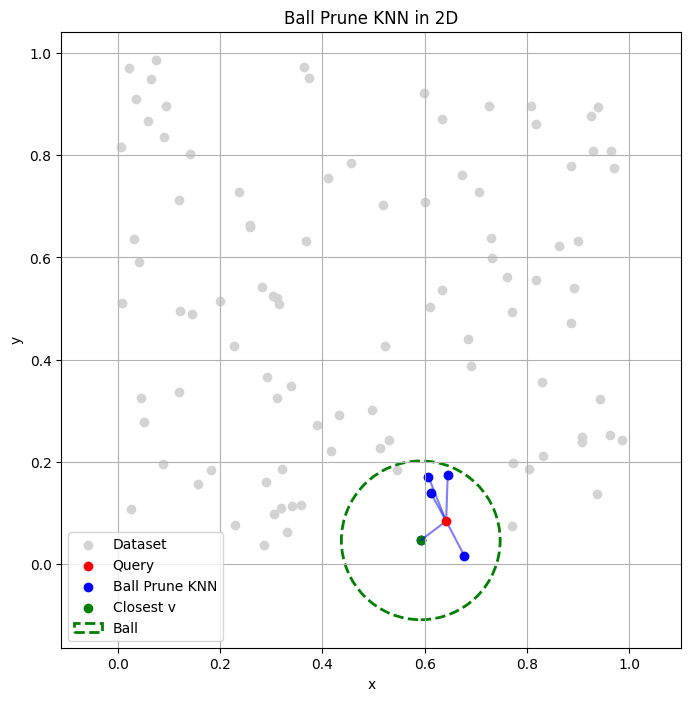

In [28]:
import matplotlib.pyplot as plt

# --- Generate Random 2D Dataset ---
np.random.seed(42)
n = 100
d = 2
k = 5
m = 10
dataset = np.random.rand(n, d)
query = np.random.rand(d)

# --- Precompute min_dists and max_dists ---
min_dists = {}
max_dists = {}

for i in range(n):
    dists = [(j, euclidean_distance(dataset[i], dataset[j])) for j in range(n) if i != j]
    dists.sort(key=lambda x: x[1])
    min_dists[i] = dists[:m]
    max_dists[i] = dists[-m:]

# --- Run Ball Prune ---
ball_results = ball_prune_knn(query, dataset, k, min_dists, max_dists)
ball_indices = [idx for _, idx in ball_results]
v = dataset[ball_indices[0]]
R = max([euclidean_distance(query, dataset[idx]) for idx in ball_indices])
ball_radius = euclidean_distance(query, v) + R

# --- Plot Results ---
plt.figure(figsize=(8, 8))
plt.scatter(dataset[:, 0], dataset[:, 1], c='lightgray', label='Dataset')
plt.scatter(query[0], query[1], c='red', label='Query', zorder=5)
plt.scatter(dataset[ball_indices, 0], dataset[ball_indices, 1], c='blue', label='Ball Prune KNN')
plt.scatter(v[0], v[1], c='green', label='Closest v')
circle = plt.Circle((v[0], v[1]), ball_radius, color='green', fill=False, linestyle='--', linewidth=2, label='Ball')
plt.gca().add_patch(circle)

# Connect query to its kNN
for i in ball_indices:
    plt.plot([query[0], dataset[i, 0]], [query[1], dataset[i, 1]], color='blue', alpha=0.5)

plt.title("Ball Prune KNN in 2D")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.legend()
plt.grid(True)
plt.show()